In [6]:
%matplotlib inline

import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import fbprophet
import matplotlib.pyplot as plt
# import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


from src import dataset

In [7]:
excel_file = "20160921-analysisofestimatedarrivals.xlsx"
df = dataset.load_excel(excel_file)


In [8]:
df_italy = df.iloc[:, 0:1] # Arrivals to Italy
df_greek_island = df.iloc[:, 1:2] # Arrivals to Greek Island
df_mainland_greece = df.iloc[:, 2:3] # Arrivals to Mainland greece
df_fyrom = df.iloc[:, 3:4] # Arrivals to fYRoM
df_serbia = df.iloc[:, 4:5] # Arrivals to Serbia
df_croatia = df.iloc[:, 5:6] # Arrivals to Croatia
df_hungry = df.iloc[:, 6:7] # Arrivals to Hungry
df_slovenia = df.iloc[:, 7:8] # Arrivals to Slovenia
df_austria = df.iloc[:, 8:9] # Arrivals to Austria

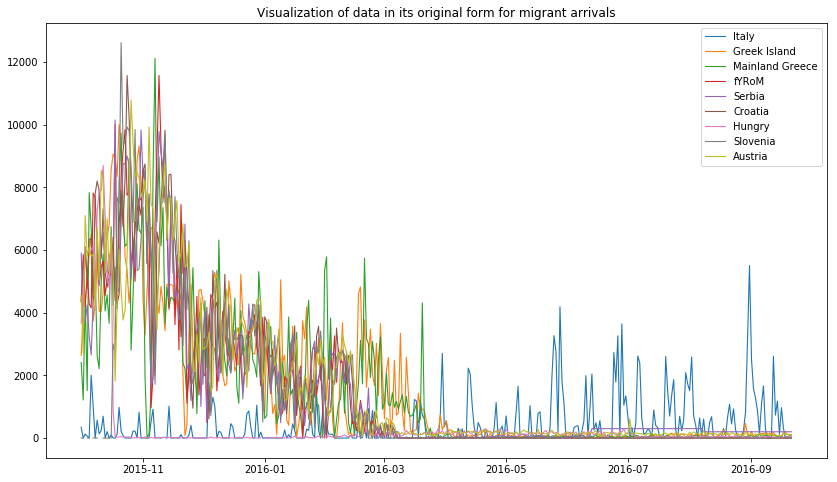

In [25]:
plt.figure(figsize=(14,8))
plt.plot(df_italy.index, df_italy.iloc[:, 0], label="Italy", linewidth=1.1)
plt.plot(df_greek_island.index, df_greek_island.iloc[:, 0], label="Greek Island", linewidth=1.1)
plt.plot(df_mainland_greece.index, df_mainland_greece.iloc[:, 0], label="Mainland Greece", linewidth=1.1)
plt.plot(df_fyrom.index, df_fyrom.iloc[:, 0], label="fYRoM", linewidth=1.1)
plt.plot(df_serbia.index, df_serbia.iloc[:, 0], label="Serbia", linewidth=1.1)
plt.plot(df_croatia.index, df_croatia.iloc[:, 0], label="Croatia", linewidth=1.1)
plt.plot(df_hungry.index, df_hungry.iloc[:, 0], label="Hungry", linewidth=1.1)
plt.plot(df_slovenia.index, df_slovenia.iloc[:, 0], label="Slovenia", linewidth=1.1)
plt.plot(df_austria.index, df_austria.iloc[:, 0], label="Austria", linewidth=1.1)
plt.legend(loc="best")
plt.title("Visualization of data in its original form for migrant arrivals")
plt.show()

In [9]:
df = df_mainland_greece # Seriies to test

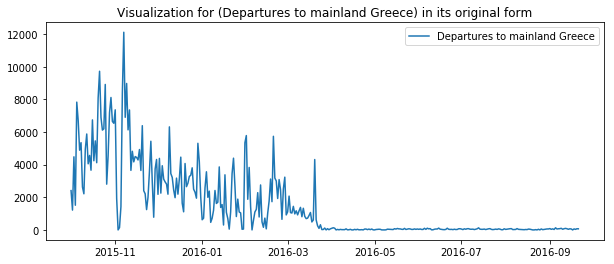

In [10]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df.iloc[:, 0], label=df.columns[0])
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.show()

In [11]:
df.head()

,Departures to mainland Greece
Date,
2015-10-01,2409
2015-10-02,1215
2015-10-03,4480
2015-10-04,1513
2015-10-05,7833


In [12]:
df.tail()

,Departures to mainland Greece
Date,
2016-09-17,0
2016-09-18,61
2016-09-19,34
2016-09-20,71
2016-09-21,67


In [13]:
rollmean  = df.rolling(window=30).mean()
rollstd  = df.rolling(window=30).std()

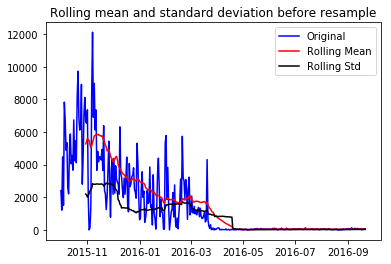

In [14]:
orig = plt.plot(df, color="blue", label="Original")
mean = plt.plot(rollmean, color="red", label="Rolling Mean")
std = plt.plot(rollstd, color="black", label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling mean and standard deviation before resample")
plt.show(block=False)

In [15]:
# Resample by weeks
w_df = df.resample("W").sum()
w_df = w_df.reset_index().rename(columns={'Date': 'ds', df.columns[0]: 'y'})
w_df = w_df.set_index("ds")


In [16]:
w_df['y'] = w_df['y'].replace(to_replace=0, method='ffill')
w_df.head()

,y
ds,
2015-10-04,9617
2015-10-11,34570
2015-10-18,34594
2015-10-25,50054
2015-11-01,43198


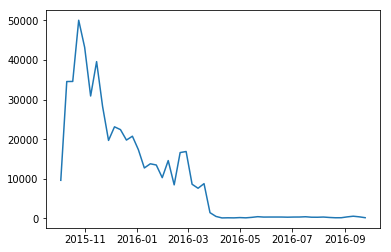

In [17]:
plt.plot(w_df.index, w_df["y"])
plt.show()

In [18]:
#Stationarity test
def test_stationarity(timeseries, win_size=7):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=win_size).mean()
    rolstd = timeseries.rolling(window=win_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, linewidth=1.2,label='Original')
    mean = plt.plot(rolmean, linewidth=1.2, label='Rolling Mean')
    std = plt.plot(rolstd, linewidth=1.2, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[timeseries.columns[0]], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

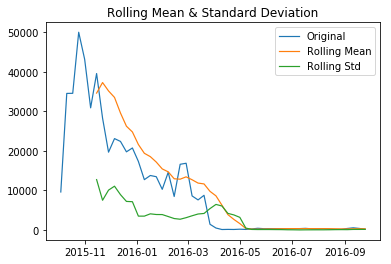

Results of Dickey-Fuller Test:
Test Statistic                 -5.642339
p-value                         0.000001
#Lags Used                      3.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [19]:
test_stationarity(w_df)

(52, 1)


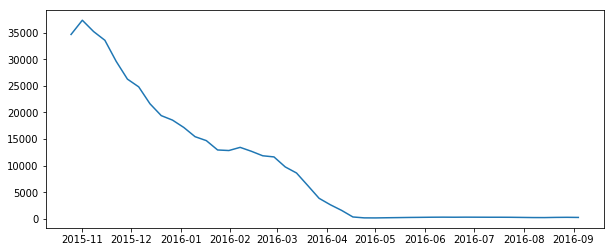

In [28]:
plt.figure(figsize=(10,4))
# w_df = w_df.reset_index()
df[df.columns[0]] = df[df.columns[0]].replace(to_replace=0, method='ffill')
logged = np.log(w_df)
print(w_df.shape)

# logged = np.log(df)
# df['Arrivals to Italy'] = df['Arrivals to Italy'].replace(to_replace=0, method='ffill')
decomposition = seasonal_decompose(w_df, freq=7, model="additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.plot(trend)
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


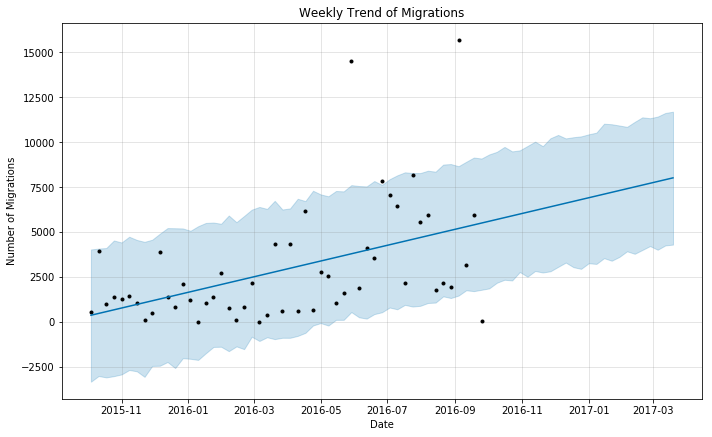

In [54]:
ph_model = fbprophet.Prophet(changepoint_prior_scale=0.14)
ph_model.fit(w_df)
ph_forecast = ph_model.make_future_dataframe(periods=25, freq='W')
ph_forecast = ph_model.predict(ph_forecast)

ph_model.plot(ph_forecast, xlabel = 'Date', ylabel = 'Number of Migrations')
plt.title('Weekly Trend of Migrations')
plt.show()

In [ ]:
# Commands to remember

df.sort_values("ColumnName").head() # Sort by column name
df.loc["2016-03-06"] # Find a value by certain index date
df.groupby(df.iloc[:, 0]).count().head() # Count all vaues in certain series
df.isnull().sum() # Sum of nulls